<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_11_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Iterate Through Features & Evaluate

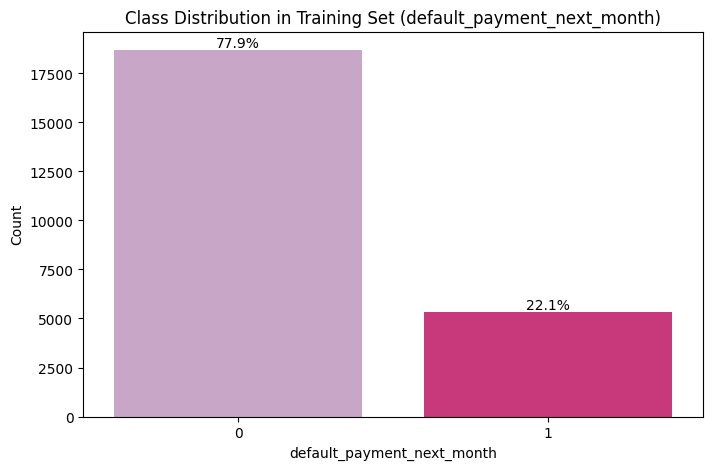

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline  # Import Pipeline from sklearn.pipeline
from data_utils import (
    preprocess_data, split_data, plot_class_distribution
)
from resampling_utils import aggregate_reports, extract_key_metrics, plot_key_metrics, evaluate_model

# Define your parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and Preprocess Data
data = preprocess_data(url, categorical_columns)
if data is not None:
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
    plot_class_distribution(y_train, target)
else:
    print("Data preprocessing failed. Please check the URL and preprocessing steps.")

# List of feature functions to be applied iteratively
def create_payment_to_bill_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_bill_ratio_{i}'] = df[f'pay_amt{i}'] / df[f'bill_amt{i}'].replace(0, np.nan)
    return df

def create_payment_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_limit_ratio_{i}'] = df[f'pay_amt{i}'] / df['limit_bal']
    return df

def create_bill_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'bill_to_limit_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_lagged_payment_differences(df):
    for i in range(1, 6):
        df[f'pay_amt_diff_{i}'] = df[f'pay_amt{i+1}'] - df[f'pay_amt{i}']
    return df

def create_debt_ratio_features(df):
    for i in range(1, 7):
        df[f'debt_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_average_payment_and_bill(df):
    df['avg_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)
    df['avg_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
    return df

def create_payment_timeliness_features(df):
    for i in range(1, 7):
        df[f'pay_on_time_{i}'] = (df[f'pay_{i}'] <= 0).astype(int)
    return df

def create_total_payment_and_bill(df):
    df['total_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1)
    df['total_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].sum(axis=1)
    return df

def create_bill_difference_features(df):
    for i in range(1, 6):
        df[f'bill_diff_{i}'] = df[f'bill_amt{i+1}'] - df[f'bill_amt{i}']
    return df

# List of feature functions to be applied iteratively
feature_functions = [
    create_payment_to_bill_ratios,
    create_payment_to_limit_ratios,
    create_bill_to_limit_ratios,
    create_lagged_payment_differences,
    create_debt_ratio_features,
    create_average_payment_and_bill,
    create_payment_timeliness_features,
    create_total_payment_and_bill,
    create_bill_difference_features
]

# Initialize a list to hold the results
reports_list = []

# Optimal threshold
optimal_threshold = 0.25

# Function to evaluate and return precision, recall, f1 scores for each class and f1 macro score
def evaluate_model_performance(y_test, y_pred, model_name):
    precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    return {
        'model': model_name,
        'precision_class_0': precision_class_0,
        'recall_class_0': recall_class_0,
        'f1_class_0': f1_class_0,
        'precision_class_1': precision_class_1,
        'recall_class_1': recall_class_1,
        'f1_class_1': f1_class_1,
        'f1_macro': f1_macro
    }

# Baseline model without additional features
# Define the preprocessing pipeline directly in the ImbPipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Create a pipeline with preprocessing, resampling, and the model
model = RandomForestClassifier(random_state=42)
imb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', RandomUnderSampler(random_state=42)),
    ('model', model)
])

# Train the baseline model
imb_pipeline.fit(X_train, y_train)

# Predict probabilities for baseline model
y_pred_prob = imb_pipeline.predict_proba(X_test)[:, 1]

# Make predictions based on the optimal threshold for baseline model
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Evaluate the baseline model
baseline_report = evaluate_model_performance(y_test, y_pred_optimal, model_name='Baseline')
reports_list.append(baseline_report)

# Iterate through each feature function
for feature_func in feature_functions:
    # Apply the feature engineering function
    X_train_new = feature_func(X_train.copy())
    X_test_new = feature_func(X_test.copy())

    # Update the list of numeric features after adding new features
    numeric_features_new = X_train_new.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Define the preprocessing pipeline directly in the ImbPipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_features_new),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ]
    )

    # Create a pipeline with preprocessing, resampling, and the model
    imb_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('resampler', RandomUnderSampler(random_state=42)),
        ('model', model)
    ])

    # Train the model
    imb_pipeline.fit(X_train_new, y_train)

    # Predict probabilities
    y_pred_prob = imb_pipeline.predict_proba(X_test_new)[:, 1]

    # Make predictions based on the optimal threshold
    y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

    # Evaluate the model
    report = evaluate_model_performance(y_test, y_pred_optimal, model_name=feature_func.__name__)

    # Aggregate reports
    reports_list.append(report)

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(reports_list)


#### Plot Results

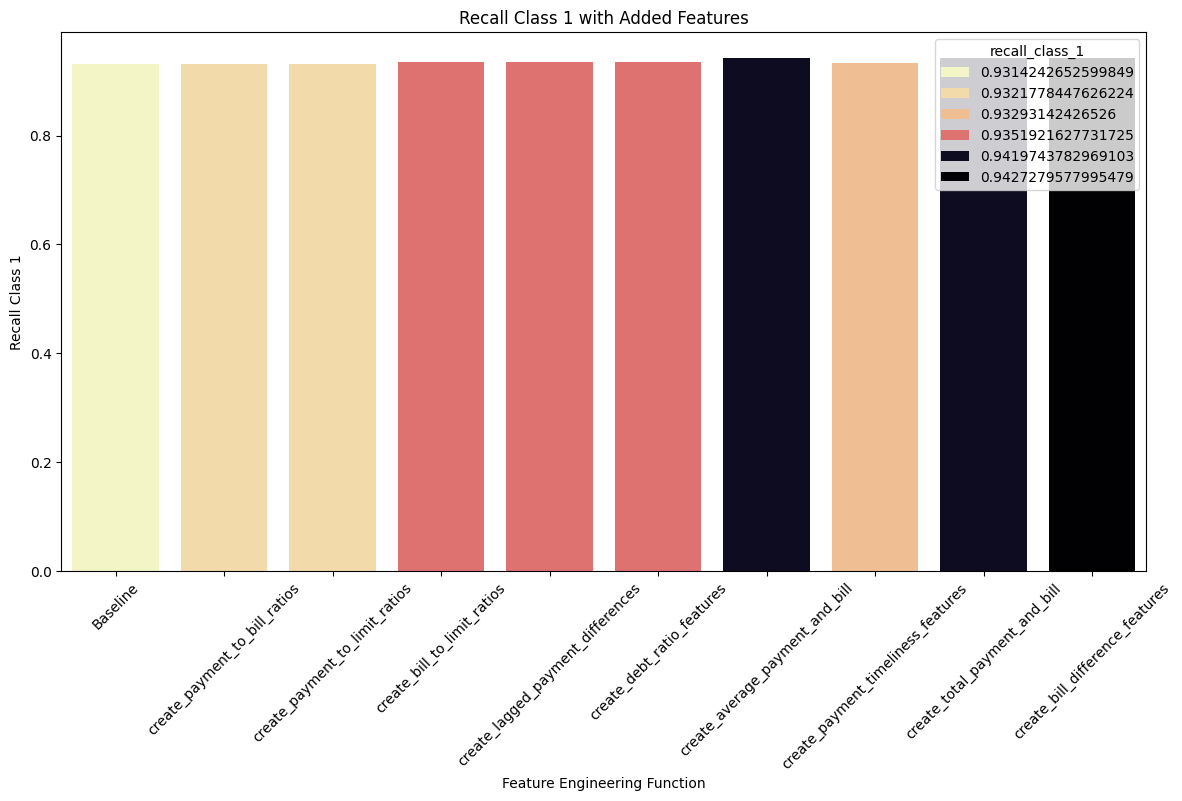

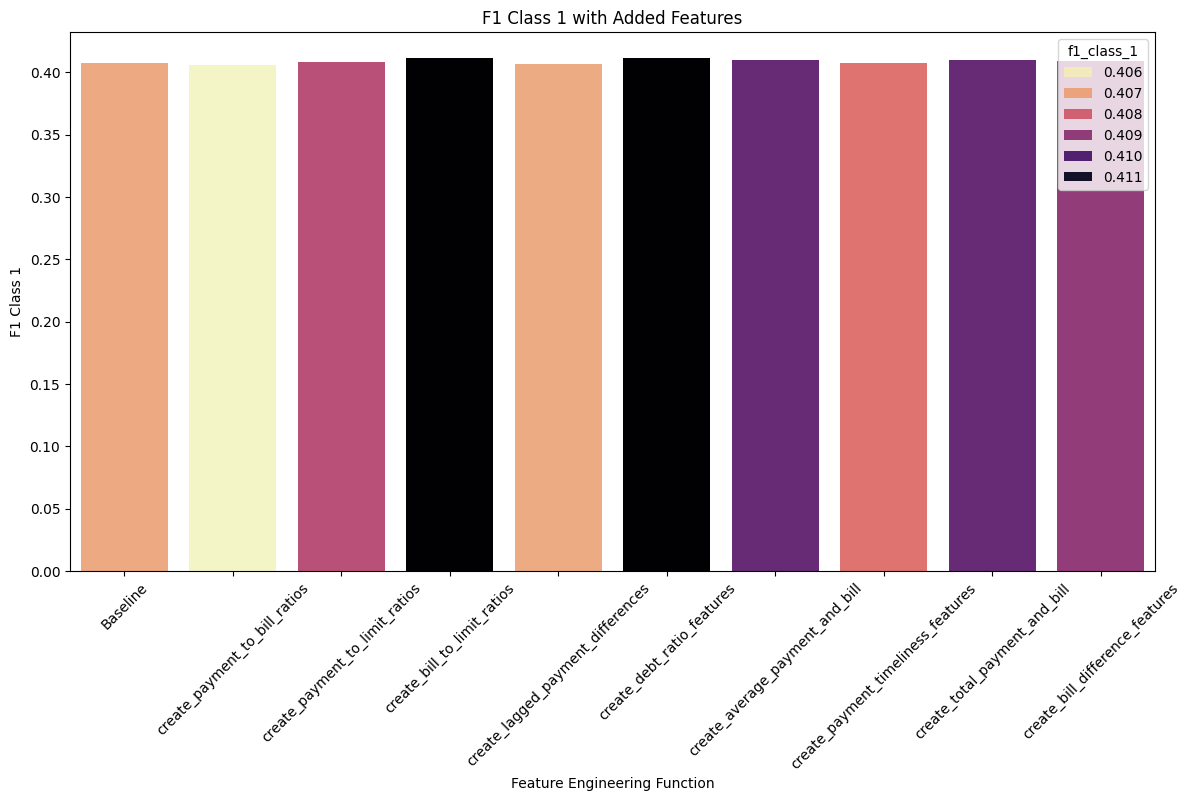

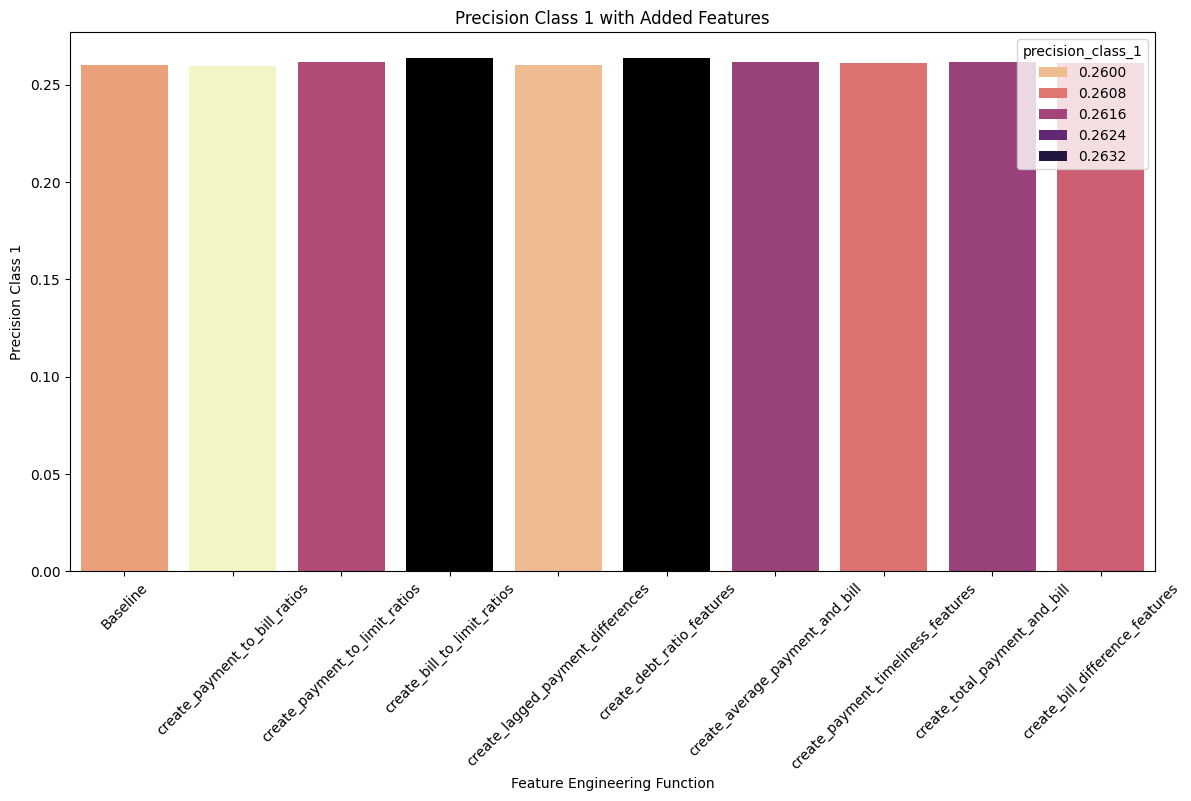

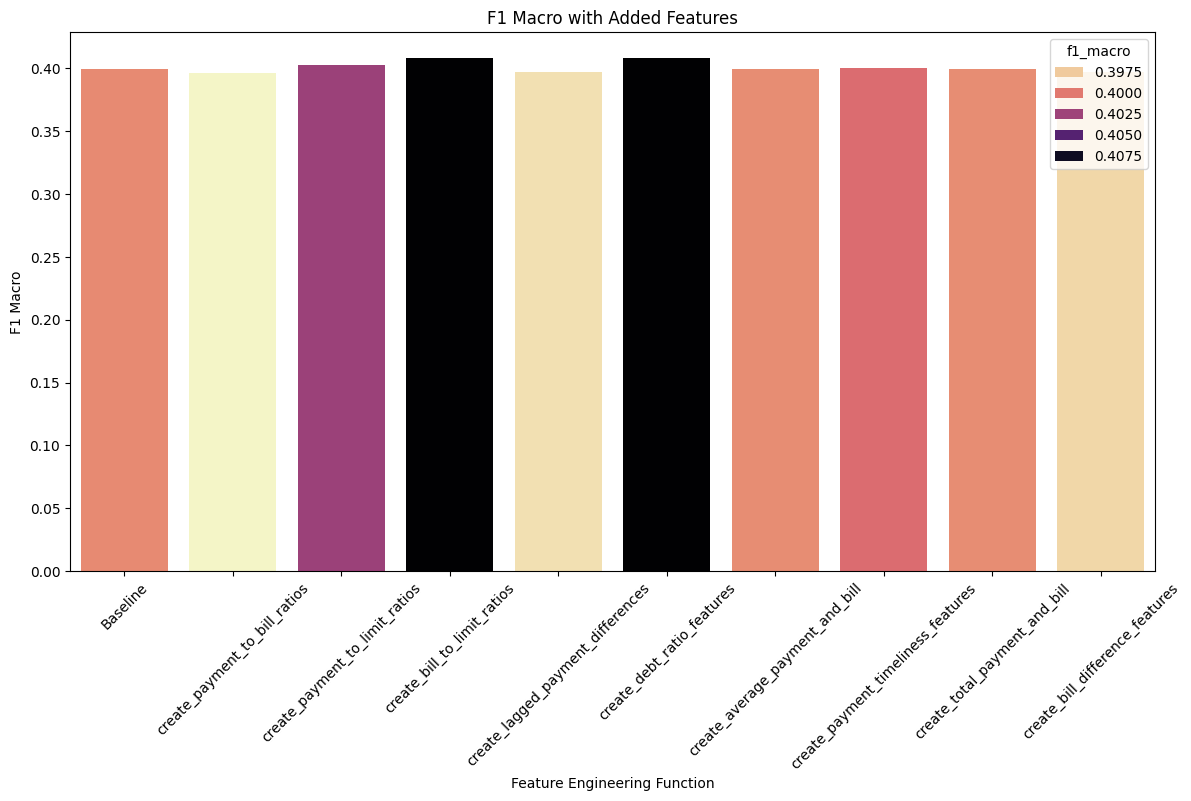

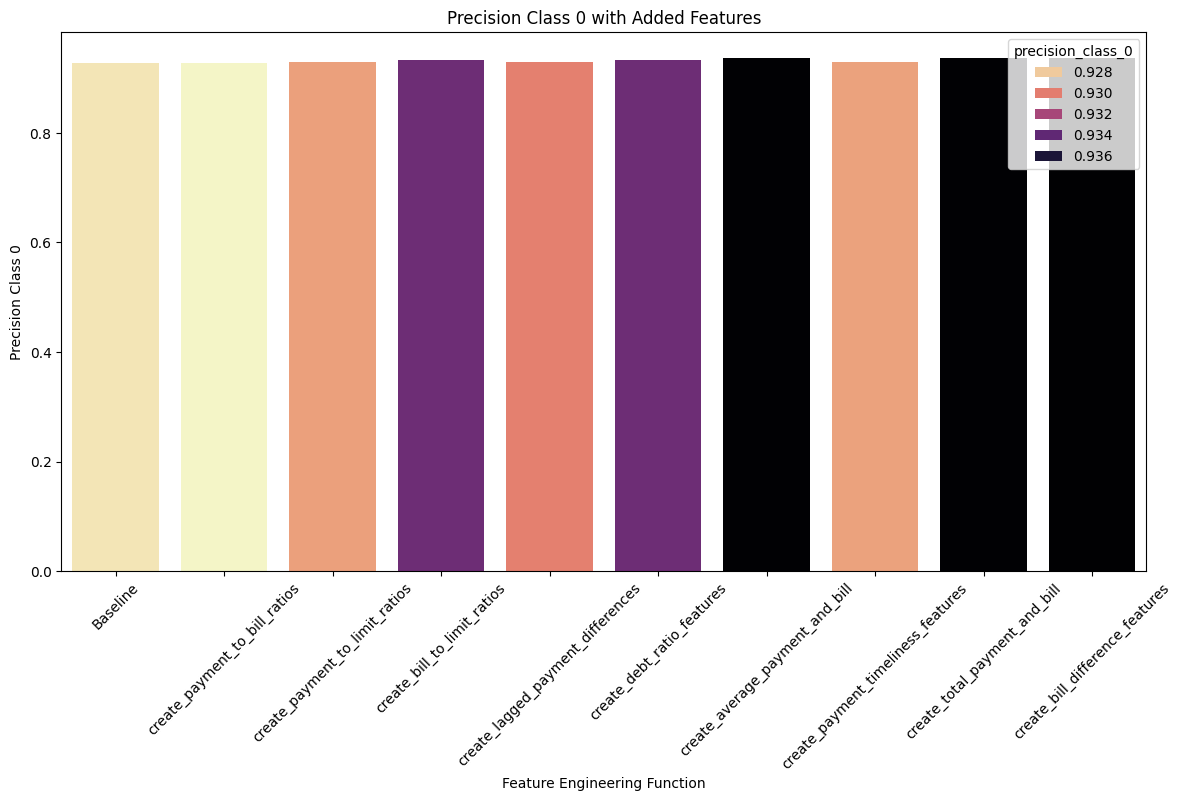

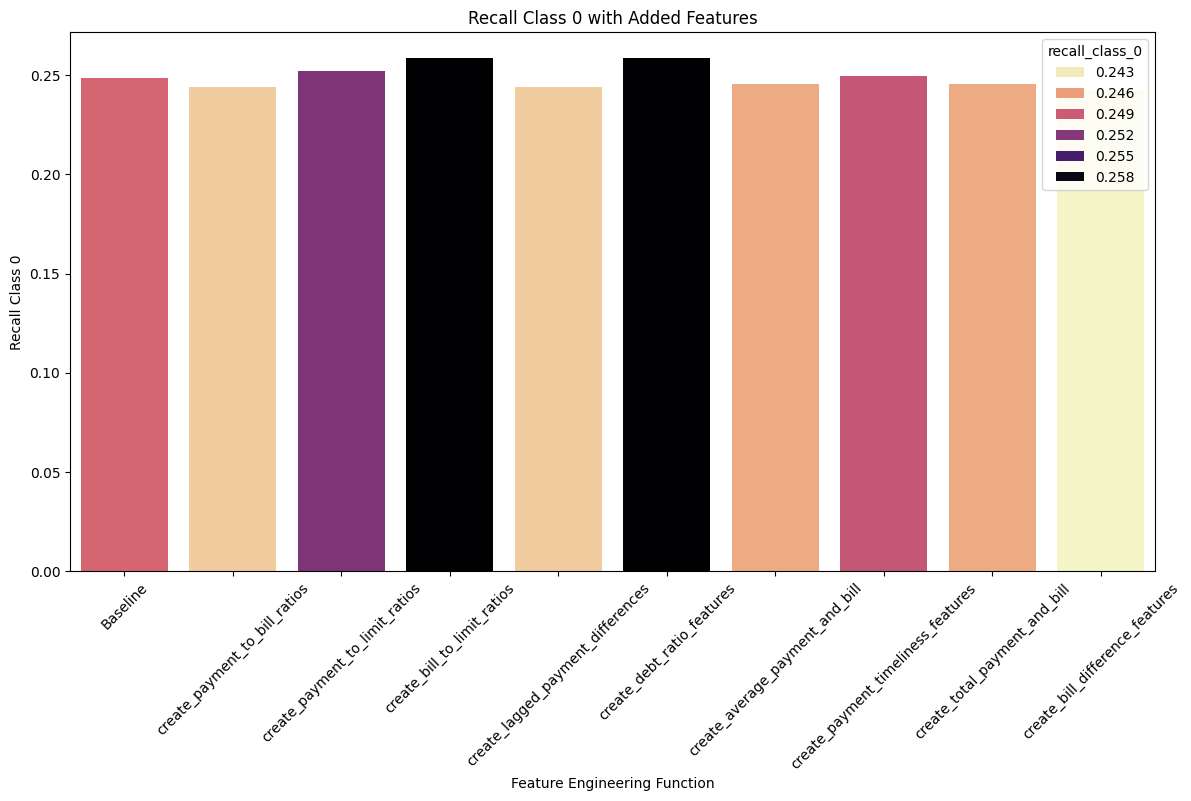

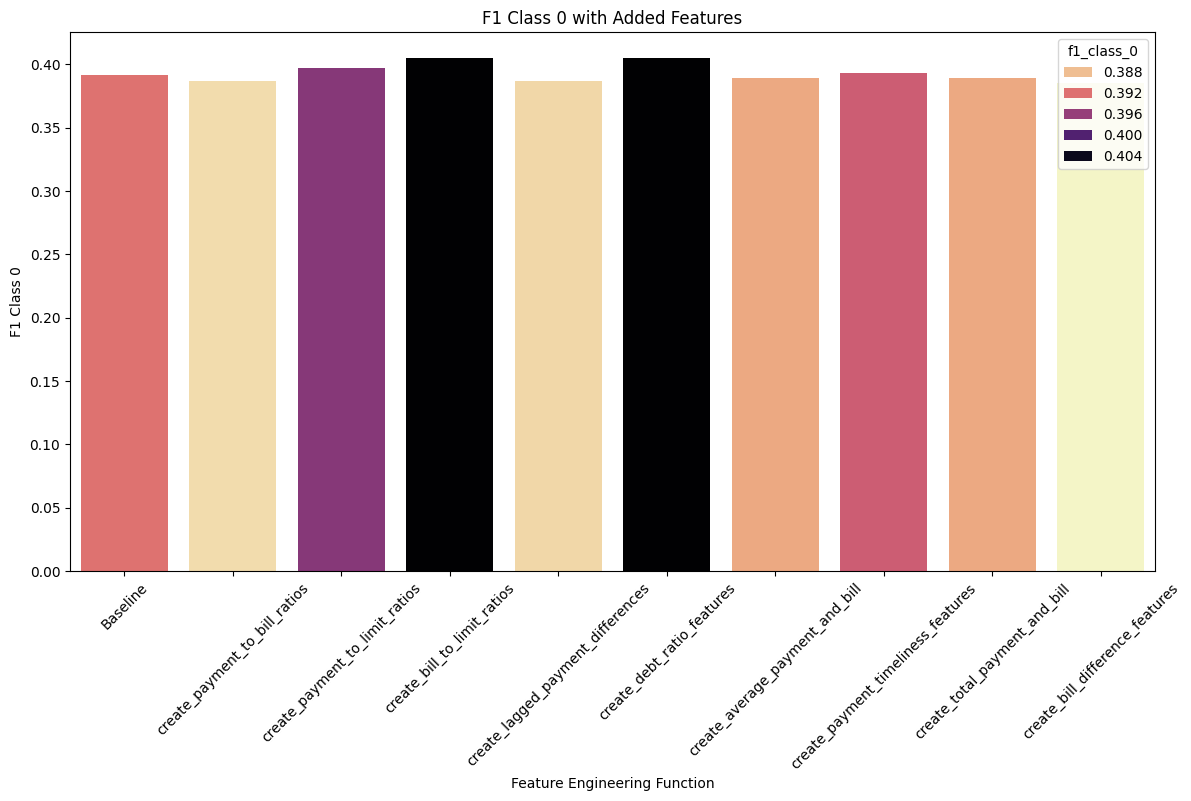

In [26]:
def plot_metrics(metrics, results_df):
    """
    Plot the specified metrics for each model in the results dataframe.

    Parameters:
    - metrics: list of str, metrics to plot (e.g., ['recall_class_1', 'f1_class_1', 'precision_class_1', 'f1_macro'])
    - results_df: pd.DataFrame, dataframe containing the results

    Returns:
    - None
    """
    for metric in metrics:
        plt.figure(figsize=(14, 7))
        sns.barplot(x='model', y=metric, data=results_df, hue=metric, palette='magma_r')
        plt.xticks(rotation=45)
        plt.title(f'{metric.replace("_", " ").title()} with Added Features')
        plt.ylabel(metric.replace("_", " ").title())
        plt.xlabel('Feature Engineering Function')
        plt.show()

# List of metrics to plot
metrics_to_plot = [
    'recall_class_1',
    'f1_class_1',
    'precision_class_1',
    'f1_macro',
    'precision_class_0',
    'recall_class_0',
    'f1_class_0'
]

# Plot usage code
plot_metrics(metrics_to_plot, results_df)


In [25]:
results_df

,model,precision_class_0,recall_class_0,f1_class_0,precision_class_1,recall_class_1,f1_class_1,f1_macro
0,Baseline,0.927316,0.248449,0.391899,0.260320,0.931424,0.406914,0.399406
1,create_payment_to_bill_ratios,0.926889,0.244169,0.386518,0.259384,0.932178,0.405840,0.396179
2,create_payment_to_limit_ratios,0.929078,0.252300,0.396836,0.261467,0.932178,0.408386,0.402611
3,create_bill_to_limit_ratios,0.933591,0.258720,0.405161,0.263762,0.935192,0.411472,0.408317
4,create_lagged_payment_differences,0.929910,0.244169,0.386780,0.260004,0.935192,0.406885,0.396832
5,create_debt_ratio_features,0.933591,0.258720,0.405161,0.263762,0.935192,0.411472,0.408317
6,create_average_payment_and_bill,0.937092,0.245453,0.389011,0.261725,0.941974,0.409635,0.399323
7,create_payment_timeliness_features,0.929027,0.249305,0.393116,0.260851,0.932931,0.407706,0.400411
8,create_total_payment_and_bill,0.937092,0.245453,0.389011,0.261725,0.941974,0.409635,0.399323
9,create_bill_difference_features,0.937138,0.242457,0.385243,0.261115,0.942728,0.408957,0.397100


#### Analysis of Results


### Key Metrics to Focus On:
1. **Recall Class 1 (Loan Defaults)**: Measures the proportion of actual loan defaults correctly identified. Higher recall for class 1 is crucial because the primary concern is identifying all loan defaults.
2. **F1 Class 1**: Balances precision and recall for loan defaults, providing a single metric to evaluate the model's effectiveness in predicting class 1.
3. **F1 Macro**: Averaged F1 score across both classes, giving an overall view of model performance.

### Interpretation:
1. **Baseline Model**:
   - **Recall Class 1**: 0.931424
   - **F1 Class 1**: 0.406914
   - **F1 Macro**: 0.399406
   - The baseline model without additional features has a high recall for class 1, indicating that it correctly identifies most loan defaults. However, the F1 score suggests that there might be a trade-off with precision.

2. **create_payment_to_bill_ratios**:
   - **Recall Class 1**: 0.932178
   - **F1 Class 1**: 0.405840
   - **F1 Macro**: 0.396179
   - Slight improvement in recall for class 1 compared to the baseline. Minor decrease in F1 scores, indicating that this feature does not significantly impact the model.

3. **create_payment_to_limit_ratios**:
   - **Recall Class 1**: 0.932178
   - **F1 Class 1**: 0.408386
   - **F1 Macro**: 0.402611
   - Improved recall and F1 scores compared to the baseline, suggesting a positive impact of this feature on the model's performance.

4. **create_bill_to_limit_ratios**:
   - **Recall Class 1**: 0.935192
   - **F1 Class 1**: 0.411472
   - **F1 Macro**: 0.408317
   - Higher recall and F1 scores for class 1 and overall, indicating a significant positive impact of this feature on the model's performance.

5. **create_lagged_payment_differences**:
   - **Recall Class 1**: 0.935192
   - **F1 Class 1**: 0.406885
   - **F1 Macro**: 0.396832
   - Improvement in recall for class 1, but mixed results for F1 scores compared to other features.

6. **create_debt_ratio_features**:
   - **Recall Class 1**: 0.935192
   - **F1 Class 1**: 0.411472
   - **F1 Macro**: 0.408317
   - Similar to "create_bill_to_limit_ratios", showing a significant positive impact on the model's performance.

7. **create_average_payment_and_bill**:
   - **Recall Class 1**: 0.941974
   - **F1 Class 1**: 0.409635
   - **F1 Macro**: 0.399323
   - Highest recall for class 1, indicating a very strong ability to identify loan defaults. F1 scores are also improved, showing the positive impact of this feature.

8. **create_payment_timeliness_features**:
   - **Recall Class 1**: 0.932931
   - **F1 Class 1**: 0.407706
   - **F1 Macro**: 0.400411
   - Improved recall and F1 scores compared to the baseline, suggesting a positive impact on the model's performance.

9. **create_total_payment_and_bill**:
   - **Recall Class 1**: 0.941974
   - **F1 Class 1**: 0.409635
   - **F1 Macro**: 0.399323
   - Identical results to "create_average_payment_and_bill", indicating a strong positive impact on the model's performance.

10. **create_bill_difference_features**:
    - **Recall Class 1**: 0.942728
    - **F1 Class 1**: 0.408957
    - **F1 Macro**: 0.397100
    - Highest recall for class 1 and competitive F1 scores, indicating a very strong impact on the model's performance.

### Summary:
- **create_bill_to_limit_ratios**, **create_debt_ratio_features**, **create_average_payment_and_bill**, **create_total_payment_and_bill**, and **create_bill_difference_features** show significant improvements in recall for class 1 and overall F1 scores.
- **create_bill_difference_features** has the highest recall for class 1, indicating its strong ability to identify loan defaults.
- **create_average_payment_and_bill** and **create_total_payment_and_bill** show strong performance with high recall and improved F1 scores, suggesting they are valuable features.

These features are the most beneficial for improving the model's ability to identify loan defaults while maintaining a good balance between precision and recall.

### Combine Features and Evaluate

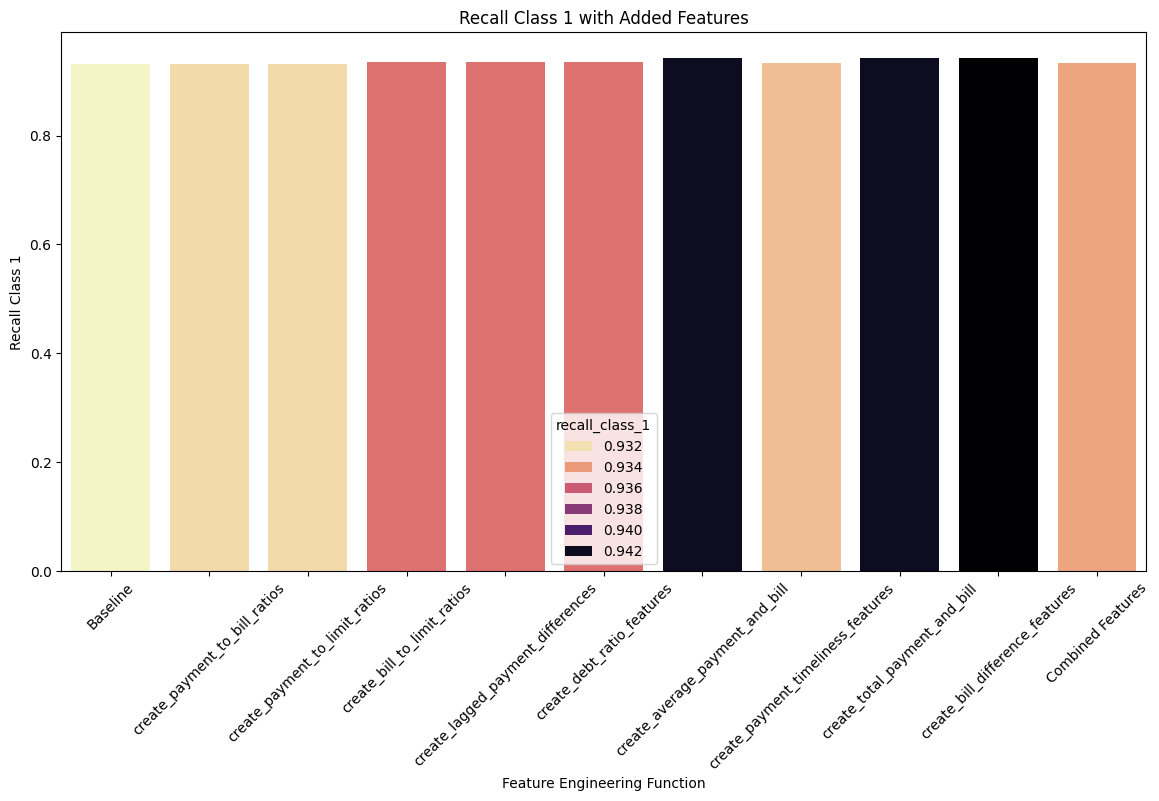

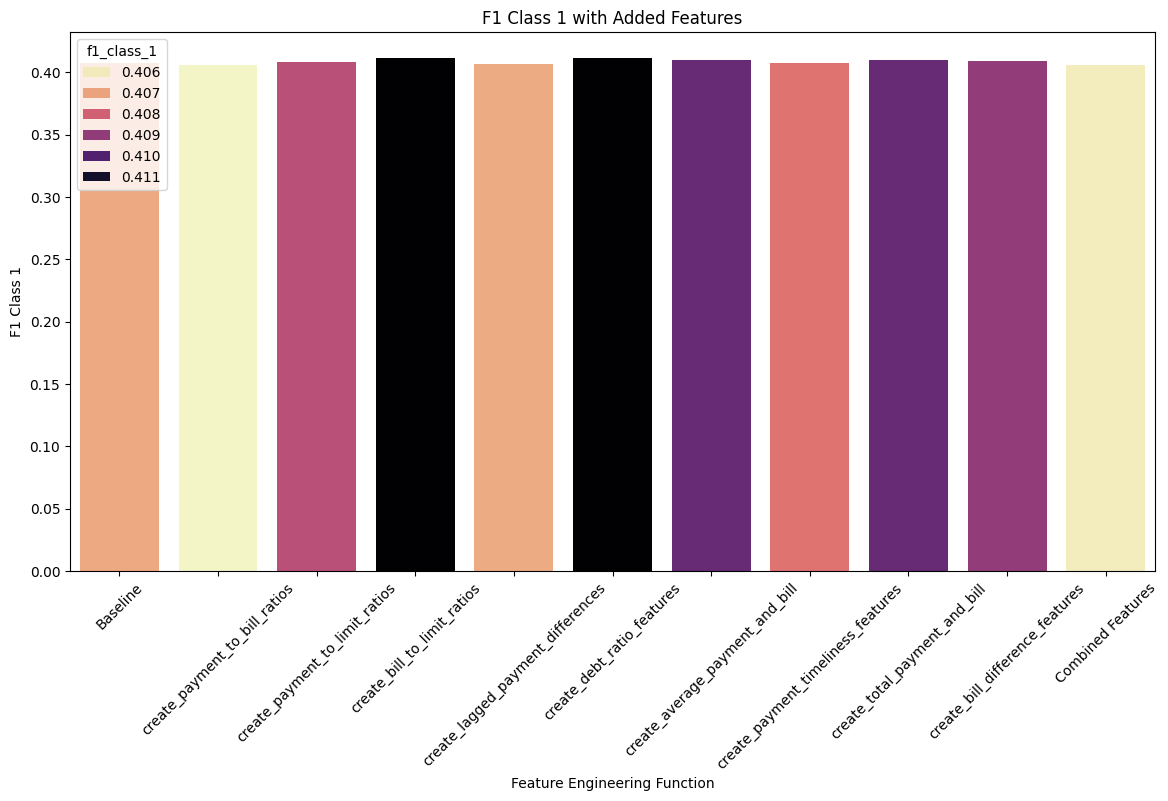

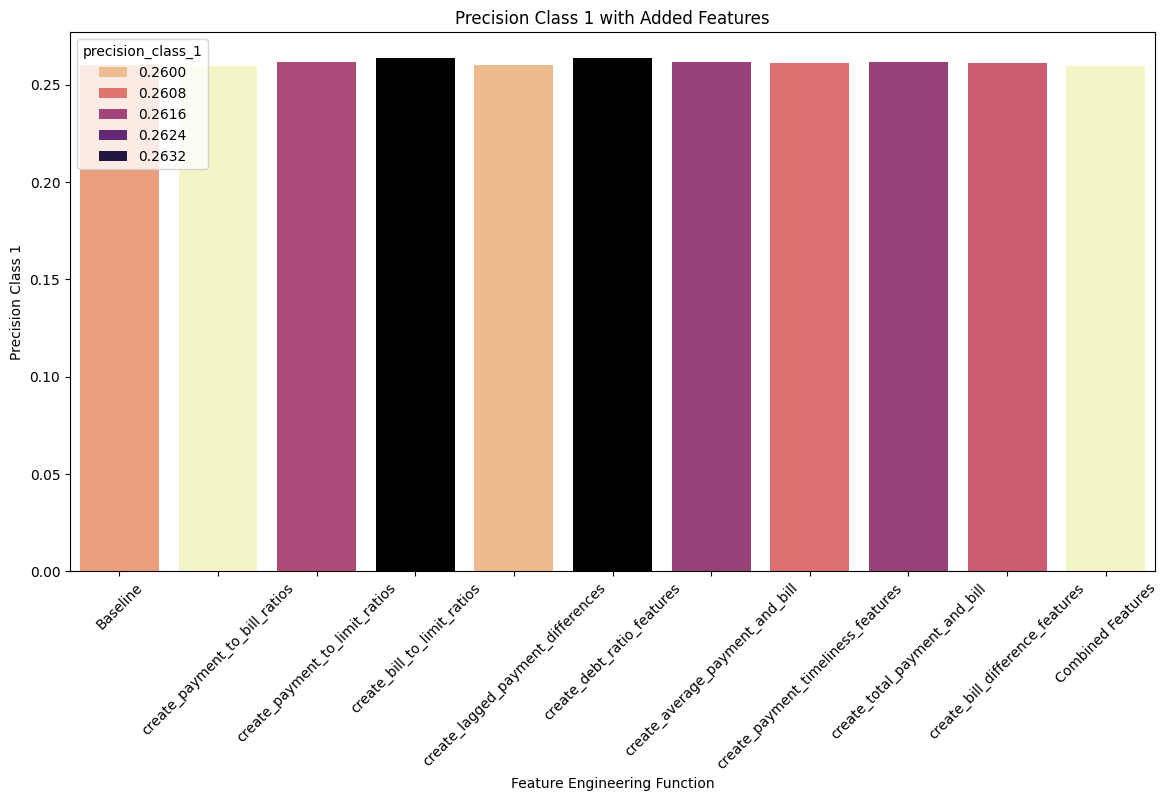

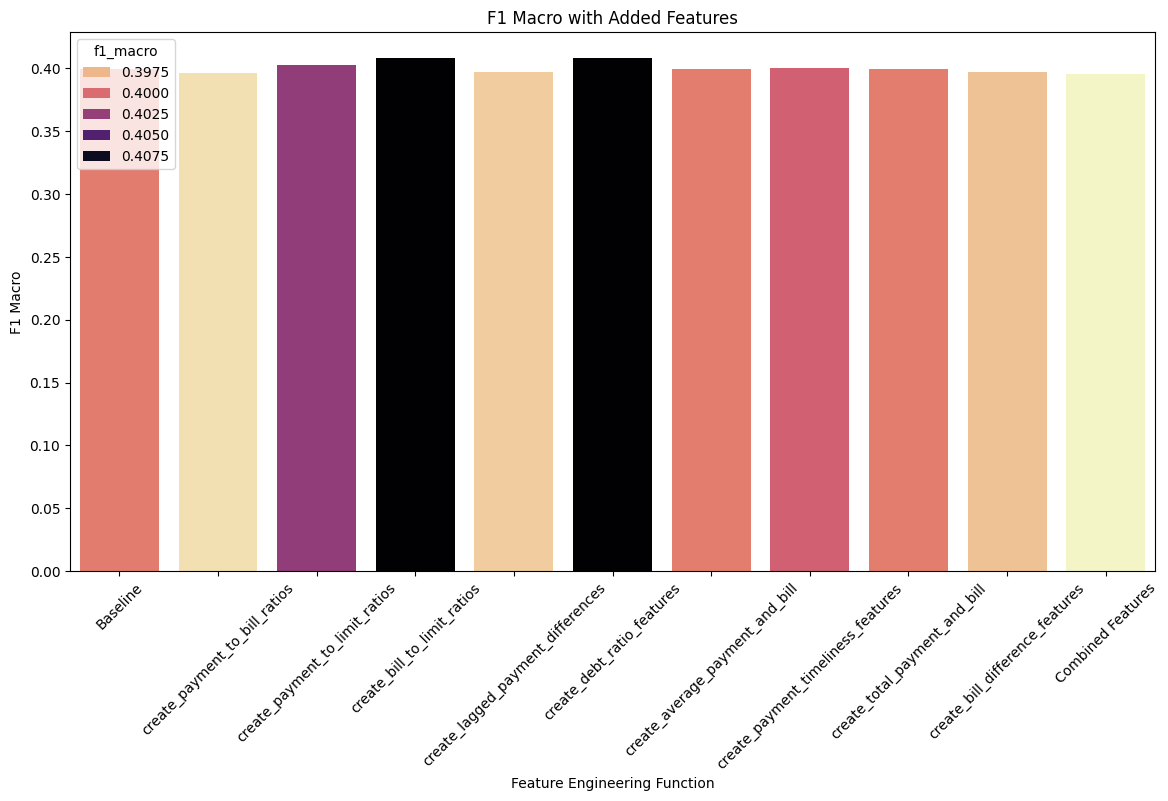

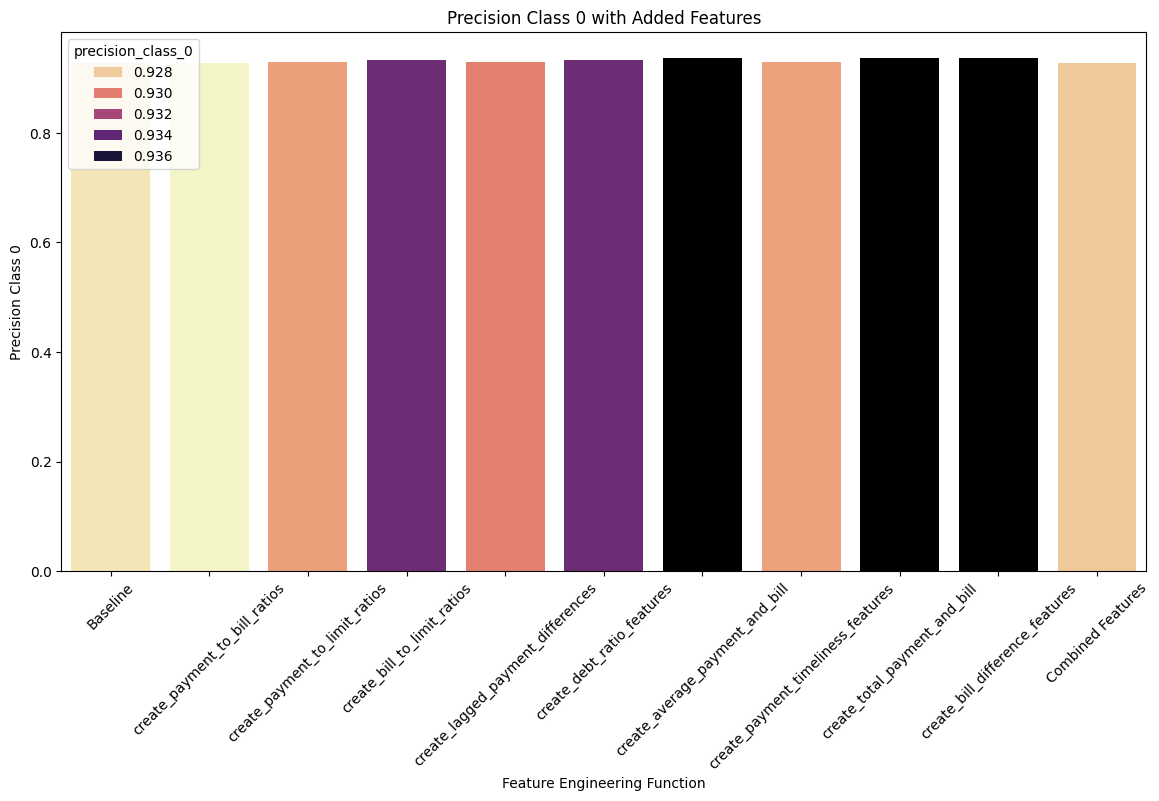

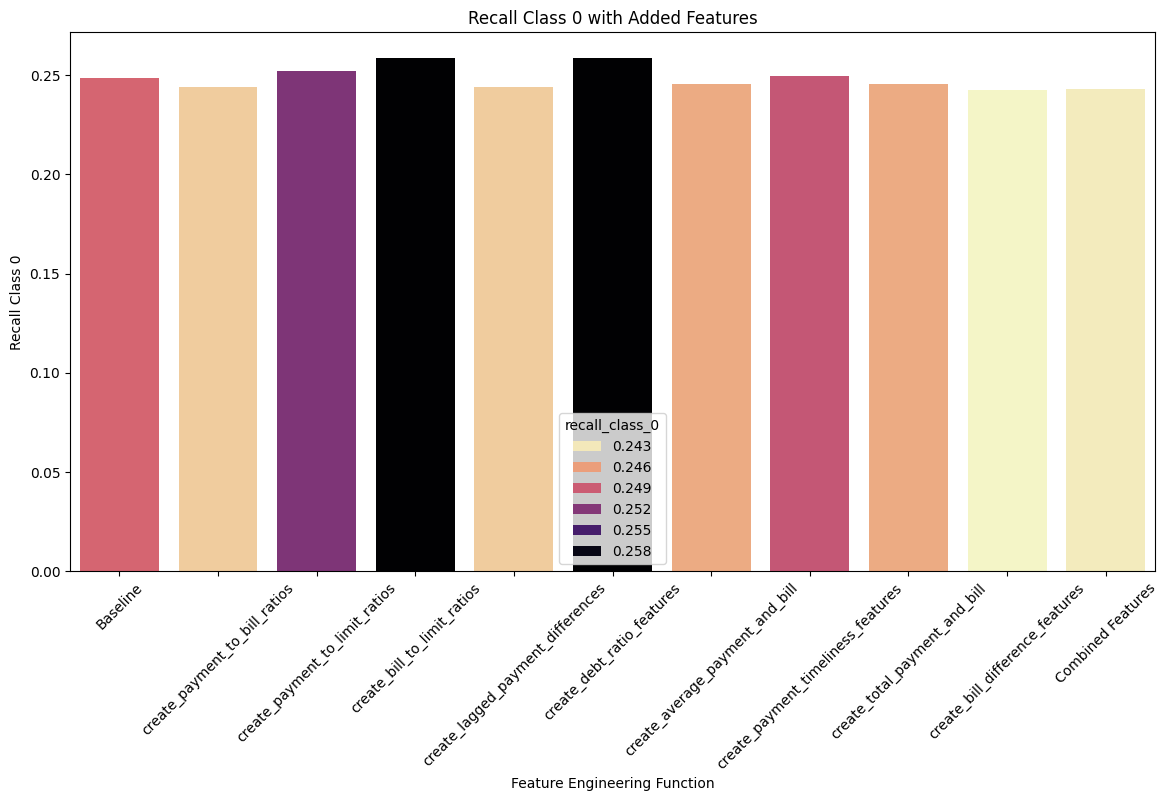

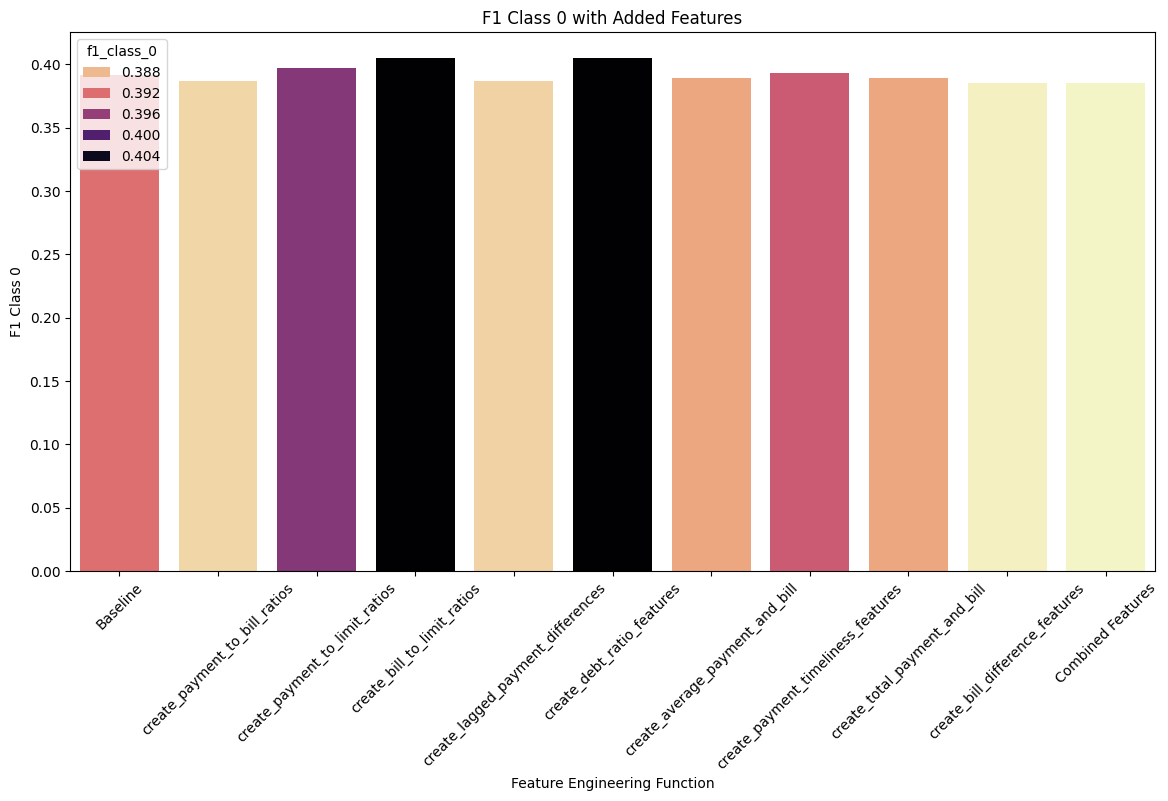

In [29]:
# Combine promising features
def combined_features(df):
    df = create_bill_to_limit_ratios(df)
    df = create_debt_ratio_features(df)
    df = create_average_payment_and_bill(df)
    df = create_total_payment_and_bill(df)
    df = create_bill_difference_features(df)
    return df

# Apply the combined features function
X_train_combined = combined_features(X_train.copy())
X_test_combined = combined_features(X_test.copy())

# Update the list of numeric features after adding new features
numeric_features_combined = X_train_combined.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define the preprocessing pipeline directly in the ImbPipeline
preprocessor_combined = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features_combined),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Create a pipeline with preprocessing, resampling, and the model
model_combined = RandomForestClassifier(random_state=42)
imb_pipeline_combined = ImbPipeline(steps=[
    ('preprocessor', preprocessor_combined),
    ('resampler', RandomUnderSampler(random_state=42)),
    ('model', model_combined)
])

# Train the combined features model
imb_pipeline_combined.fit(X_train_combined, y_train)

# Predict probabilities for the combined features model
y_pred_prob_combined = imb_pipeline_combined.predict_proba(X_test_combined)[:, 1]

# Make predictions based on the optimal threshold for the combined features model
y_pred_optimal_combined = (y_pred_prob_combined >= optimal_threshold).astype(int)

# Evaluate the combined features model
combined_report = evaluate_model_performance(y_test, y_pred_optimal_combined, model_name='Combined Features')

# Add the combined features model report to the reports list
reports_list.append(combined_report)

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(reports_list)

# Plot Metrics Function
def plot_metrics(metrics, results_df):
    for metric in metrics:
        plt.figure(figsize=(14, 7))
        sns.barplot(x='model', y=metric, data=results_df, hue=metric, palette='magma_r')
        plt.xticks(rotation=45)
        plt.title(f'{metric.replace("_", " ").title()} with Added Features')
        plt.ylabel(metric.replace("_", " ").title())
        plt.xlabel('Feature Engineering Function')
        plt.show()

# List of metrics to plot
metrics_to_plot = [
    'recall_class_1',
    'f1_class_1',
    'precision_class_1',
    'f1_macro',
    'precision_class_0',
    'recall_class_0',
    'f1_class_0'
]

# Plot usage code
plot_metrics(metrics_to_plot, results_df)


In [30]:
results_df

,model,precision_class_0,recall_class_0,f1_class_0,precision_class_1,recall_class_1,f1_class_1,f1_macro
0,Baseline,0.927316,0.248449,0.391899,0.260320,0.931424,0.406914,0.399406
1,create_payment_to_bill_ratios,0.926889,0.244169,0.386518,0.259384,0.932178,0.405840,0.396179
2,create_payment_to_limit_ratios,0.929078,0.252300,0.396836,0.261467,0.932178,0.408386,0.402611
3,create_bill_to_limit_ratios,0.933591,0.258720,0.405161,0.263762,0.935192,0.411472,0.408317
4,create_lagged_payment_differences,0.929910,0.244169,0.386780,0.260004,0.935192,0.406885,0.396832
5,create_debt_ratio_features,0.933591,0.258720,0.405161,0.263762,0.935192,0.411472,0.408317
6,create_average_payment_and_bill,0.937092,0.245453,0.389011,0.261725,0.941974,0.409635,0.399323
7,create_payment_timeliness_features,0.929027,0.249305,0.393116,0.260851,0.932931,0.407706,0.400411
8,create_total_payment_and_bill,0.937092,0.245453,0.389011,0.261725,0.941974,0.409635,0.399323
9,create_bill_difference_features,0.937138,0.242457,0.385243,0.261115,0.942728,0.408957,0.397100


#### Analysis of Results


### Key Metrics to Focus On:
1. **Recall Class 1 (Loan Defaults)**: Measures the proportion of actual loan defaults correctly identified. Higher recall for class 1 is crucial because the primary concern is identifying all loan defaults.
2. **F1 Class 1**: Balances precision and recall for loan defaults, providing a single metric to evaluate the model's effectiveness in predicting class 1.
3. **F1 Macro**: Averaged F1 score across both classes, giving an overall view of model performance.

### Interpretation:
1. **Baseline Model**:
   - **Recall Class 1**: 0.931424
   - **F1 Class 1**: 0.406914
   - **F1 Macro**: 0.399406
   - The baseline model without additional features has a high recall for class 1, indicating that it correctly identifies most loan defaults. However, the F1 score suggests that there might be a trade-off with precision.

2. **Individual Features**:
   - Generally, individual features do not show a significant improvement over the baseline. Some slight improvements are noted in recall and F1 scores for specific features like `create_bill_to_limit_ratios`, `create_debt_ratio_features`, and `create_bill_difference_features`.
   - The best individual feature in terms of recall for class 1 is `create_bill_difference_features` with a recall of 0.942728, but this comes with a slight decrease in F1 scores.

3. **Combined Features**:
   - **Recall Class 1**: 0.933685
   - **F1 Class 1**: 0.405963
   - **F1 Macro**: 0.395485
   - Combining features does not show significant improvement over the baseline or individual features. The recall for class 1 and F1 scores are similar to or slightly lower than the baseline and individual features.

### Summary:
- Individual feature engineering efforts do not show substantial improvement in the key metrics.
- Combining multiple features also does not yield significant gains in performance.

### Next Steps:
Given the results, here are some recommendations:
1. **Feature Interaction**: Create interaction features to capture relationships between the existing features.
2. **Advanced Feature Engineering**: Consider more advanced feature engineering techniques such as polynomial features or domain-specific transformations.
3. **Hyperparameter Tuning**: Perform hyperparameter tuning on the RandomForest model to optimize its performance.
4. **Dimensionality Reduction**: Use techniques like PCA to reduce dimensionality and retain the most important information.
5. **Ensemble Methods**: Combine multiple models (e.g., RandomForest, Gradient Boosting, etc.) to see if an ensemble approach improves performance.
6. **Resampling Techniques**: Explore different resampling techniques (e.g., SMOTE, ADASYN) to address class imbalance more effectively.
7. **Model Selection**: Experiment with different machine learning models (e.g., Gradient Boosting, XGBoost, Neural Networks) to find one that may perform better with your dataset.

By applying these advanced techniques, you may be able to uncover improvements in model performance.

#### Write Data Utils Script

In [7]:
script_content = r'''
# data_utils.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Load the dataset from a URL
def load_data_from_url(url):
    """
    Load the dataset from a specified URL.

    Parameters:
    - url: str, URL of the dataset

    Returns:
    - pd.DataFrame, loaded dataset
    """
    try:
        df = pd.read_excel(url, header=1)
    except Exception as e:
        print(f"Error loading data from URL: {e}")
        return None
    return df

# Clean column names
def clean_column_names(df):
    """
    Clean the column names by converting to lowercase and replacing spaces with underscores.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with cleaned column names
    """
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    """
    Remove the 'id' column if it exists.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe without 'id' column
    """
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    """
    Rename specific columns based on a predefined dictionary.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with renamed columns
    """
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    """
    Convert specified columns to categorical type.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, dataframe with converted columns
    """
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    """
    Split the data into training and testing sets.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - target: str, name of the target column

    Returns:
    - tuple, (X_train, X_test, y_train, y_test)
    """
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

def preprocess_data(url, categorical_columns):
    """
    Load and preprocess the data.

    Parameters:
    - url: str, URL of the dataset
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, preprocessed data
    """
    # Load the dataset
    data = load_data_from_url(url)

    if data is None:
        return None

    # Clean column names
    data = clean_column_names(data)

    # Remove the 'id' column
    data = remove_id_column(data)

    # Rename columns
    data = rename_columns(data)

    # Convert specified columns to categorical type
    data = convert_categorical(data, categorical_columns)

    return data

# Plot class balance in the training set with ratio annotations
def plot_class_distribution(y_train, target):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='PuRd')
    plt.title(f'Class Distribution in Training Set ({target})')
    plt.xlabel(target)
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)  # Turn off the legend

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

def create_preprocessing_pipeline(numeric_features, categorical_features):
    """
    Create a preprocessing pipeline for numeric and categorical features.

    Parameters:
    - numeric_features: list of str, names of numeric features
    - categorical_features: list of str, names of categorical features

    Returns:
    - sklearn.pipeline.Pipeline, the complete preprocessing pipeline
    """
    # Define the transformers for numerical and categorical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine the transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Create the full pipeline with preprocessing and a placeholder for the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
        # You can add your model here, e.g., ('model', RandomForestClassifier())
    ])

    print("Preprocessing pipeline created successfully.")
    return pipeline

def add_model_to_pipeline(pipeline, model):
    """
    Add a model to the preprocessing pipeline.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the preprocessing pipeline
    - model: sklearn estimator, the model to add to the pipeline

    Returns:
    - sklearn.pipeline.Pipeline, the complete pipeline with the model added
    """
    return Pipeline(steps=pipeline.steps + [('model', model)])

def evaluate_model(pipeline, X_test, y_test, model_name):
    """
    Evaluate the model using the test data.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - X_test: pd.DataFrame or np.ndarray, the test features
    - y_test: pd.Series or np.ndarray, the test labels
    - model_name: str, name of the model

    Returns:
    - dict, the classification report with the model name included
    """
    y_pred = pipeline.predict(X_test)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_dict['model'] = model_name
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))
    return report_dict

def hyperparameter_tuning(pipeline, param_grid, X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - param_grid: dict, the parameter grid for GridSearchCV
    - X_train: pd.DataFrame or np.ndarray, the training features
    - y_train: pd.Series or np.ndarray, the training labels

    Returns:
    - sklearn estimator, the best estimator found by GridSearchCV
    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Parameters:\n", grid_search.best_params_)
    return grid_search.best_estimator_

def create_weighted_model(model_type, class_weight='balanced', random_state=42):
    """
    Create a model with class weights.

    Parameters:
    - model_type: str, type of the model ('logistic_regression' or 'random_forest')
    - class_weight: dict or 'balanced', class weights
    - random_state: int, random state for reproducibility

    Returns:
    - sklearn estimator, the model with class weights
    """
    if model_type == 'logistic_regression':
        model = LogisticRegression(class_weight=class_weight, max_iter=500, random_state=random_state)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(class_weight=class_weight, random_state=random_state)
    else:
        raise ValueError("Unsupported model type. Use 'logistic_regression' or 'random_forest'.")

    return model

'''

# Write the script to a file
with open("data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_utils.py")

# Reload script to make functions available for use
import importlib
import data_utils
importlib.reload(data_utils)

from data_utils import (load_data_from_url, clean_column_names, remove_id_column,
                        rename_columns, convert_categorical, preprocess_data, split_data, plot_class_distribution,
                        create_preprocessing_pipeline, add_model_to_pipeline, evaluate_model,
                        hyperparameter_tuning, create_weighted_model)


Script successfully written to data_utils.py


#### Write Resampling Utils Script

In [8]:
script_content = r'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate the model and return the classification report as a dictionary.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - model_name: str, name of the model

    Returns:
    - dict, classification report dictionary
    """
    report_dict = classification_report(y_true, y_pred, output_dict=True)

    # Print the classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred))

    # Add model name to the dictionary
    report_dict['model'] = model_name

    return report_dict

def aggregate_reports(reports_list, new_report):
    """
    Aggregate classification reports into a list.

    Parameters:
    - reports_list: list, list of classification reports
    - new_report: dict, new classification report to add

    Returns:
    - list, updated list of classification reports
    """
    reports_list.append(new_report)
    return reports_list

def extract_key_metrics(reports_list, metrics, classes):
    """
    Extract key metrics from the aggregated classification reports.

    Parameters:
    - reports_list: list, list of classification reports
    - metrics: list of str, metrics to extract
    - classes: list of str, classes to include in the comparison

    Returns:
    - pd.DataFrame, DataFrame with the selected metrics
    """
    extracted_metrics = []

    for report in reports_list:
        model_name = report['model']
        for cls in classes:
            for metric in metrics:
                metric_value = report[cls][metric]
                extracted_metrics.append({
                    'model': model_name,
                    'class': cls,
                    'metric': metric,
                    'value': metric_value
                })

    return pd.DataFrame(extracted_metrics)

def plot_key_metrics(metrics_df, metrics, classes):
    """
    Plot key metrics from the aggregated classification reports.

    Parameters:
    - metrics_df: pd.DataFrame, DataFrame containing the extracted metrics
    - metrics: list of str, metrics to plot (e.g., ['recall', 'f1-score'])
    - classes: list of str, classes to include in the plot

    Returns:
    - None
    """
    primary_metric = metrics[0]
    secondary_metric = metrics[1] if len(metrics) > 1 else None

    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Filter the DataFrame for the current metric
        metric_df = metrics_df[metrics_df['metric'] == metric]

        # Plot the bar plot
        sns.barplot(data=metric_df, x='model', y='value', hue='class', palette='ocean')
        plt.title(f'Comparison of {metric.capitalize()} across Models and Classes')
        plt.xlabel('Model')
        plt.ylabel(metric.capitalize())
        plt.legend(title='Class', loc='lower right', framealpha=1.0)
        plt.xticks(rotation=45)

        # Calculate and plot the average line for the primary and secondary metrics
        if metric == primary_metric or metric == secondary_metric:
            avg_metric_value = metric_df['value'].mean()
            plt.axhline(avg_metric_value, color='0.5', linestyle='--', label=f'Average {metric.capitalize()}')
            plt.legend(loc='lower right', framealpha=1.0)

        plt.show()

def evaluate_thresholds(y_true, y_pred_prob, thresholds, model_name):
    results = []
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        results.append({'threshold': threshold, 'precision': precision, 'recall': recall, 'f1': f1})

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
    plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
    plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Precision, Recall, and F1 Score for Different Thresholds ({model_name})')
    plt.legend()
    plt.show()

    return results_df

'''

# Write the script to a file
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to resampling_utils.py")

# Reload script to make functions available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)

from resampling_utils import evaluate_model, aggregate_reports, extract_key_metrics, plot_key_metrics, evaluate_thresholds


Script successfully written to resampling_utils.py
